In [32]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import os

caminho_base = r"C:/Users/4163819/Downloads/Repositorios/Analise_de_TesteABC/CSV"
f_clientes = os.path.join(caminho_base, "clientes.csv")
f_pedidos  = os.path.join(caminho_base, "pedidos.csv")

CONFIRM_PATTERNS = [
    "%confirm%",   
    "%paid%",      
    "%pago%",      
]

CONFIRM_EQUIV = ("1","true","sim","yes","ok")


In [21]:
# Leitura de CSVs e normalização de colunas
df_clientes = pd.read_csv(f_clientes, sep=';', encoding="latin-1", dtype=str, low_memory=False)
df_pedidos  = pd.read_csv(f_pedidos,  sep=';', encoding="latin-1", dtype=str, low_memory=False)

# mostra os primeiros nomes de colunas para diagnóstico rápido
print("Colunas clientes:", df_clientes.columns.tolist()[:30])
print("Colunas pedidos :", df_pedidos.columns.tolist()[:30])

df_clientes.columns = df_clientes.columns.str.lower().str.strip()
df_pedidos.columns  = df_pedidos.columns.str.lower().str.strip()

def rename_if_exists(df, possible_names, target):
    for name in possible_names:
        if name in df.columns:
            df.rename(columns={name: target}, inplace=True)
            return True
    return False

rename_if_exists(df_clientes, ["cliente_id"], "cliente_id")
rename_if_exists(df_pedidos,  ["cliente_id"], "cliente_id")

required_clientes = {"cliente_id","grupo","estado"}
required_pedidos  = {"cliente_id","status"}

missing_clientes = required_clientes - set(df_clientes.columns)
missing_pedidos  = required_pedidos  - set(df_pedidos.columns)

if missing_clientes:
    raise ValueError(f"Faltam colunas em clientes.csv: {missing_clientes}. Renomeie-as ou ajuste o CSV.")
if missing_pedidos:
    raise ValueError(f"Faltam colunas em pedidos.csv: {missing_pedidos}. Renomeie-as ou ajuste o CSV.")

df_clientes["cliente_id"] = df_clientes["cliente_id"].astype(str).str.strip()
df_pedidos["cliente_id"]  = df_pedidos["cliente_id"].astype(str).str.strip()
df_clientes["grupo"] = df_clientes["grupo"].astype(str).str.strip().str.upper()
df_clientes["estado"] = df_clientes["estado"].astype(str).str.strip()
df_pedidos["status"] = df_pedidos["status"].astype(str).str.strip()


Colunas clientes: ['cliente_id', 'nome', 'email', 'data_cadastro', 'cidade', 'estado', 'grupo']
Colunas pedidos : ['pedido_id', 'cliente_id', 'data_pedido', 'status', 'valor_total']


In [31]:
#Registrar os DataFrames no DuckDB e montar + executar a query SQL
conn = duckdb.connect(database=":memory:")

conn.register("clientes", df_clientes)
conn.register("pedidos", df_pedidos)
confirm_where_clauses = []
for p in CONFIRM_PATTERNS:
    confirm_where_clauses.append(f"lower(p.status) LIKE lower('{p}')")

equals_clause = " OR ".join([f"lower(p.status) = '{val}'" for val in CONFIRM_EQUIV])

where_confirm = " OR ".join(confirm_where_clauses + ([equals_clause] if equals_clause else []))

sql = f"""
SELECT
  c.estado AS estado,
  c.grupo  AS grupo,
  COUNT(*) AS compras_confirmadas
FROM pedidos p
JOIN clientes c
  ON p.cliente_id = c.cliente_id
WHERE ({where_confirm})
GROUP BY c.estado, c.grupo
ORDER BY c.estado, c.grupo;
"""
df_agg = conn.execute(sql).df()
df_agg


,estado,grupo,compras_confirmadas
0,AC,A,70
1,AC,B,96
2,AC,C,52
3,AL,A,94
4,AL,B,98
...,...,...,...
76,SP,B,78
77,SP,C,74
78,TO,A,46
79,TO,B,126


In [23]:
#normalizar data_pedido 
import duckdb
import pandas as pd
import os

col = "data_pedido"

if col not in df_pedidos.columns:
    raise KeyError(f"A coluna '{col}' não existe em df_pedidos. Verifique o nome exato no CSV.")

df_pedidos[col] = df_pedidos[col].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
df_pedidos[col] = df_pedidos[col].str.replace('T', ' ', regex=False)

parsed = pd.to_datetime(df_pedidos[col], dayfirst=True, infer_datetime_format=True, errors='coerce')

mask = parsed.isna()
if mask.any():
    parsed2 = pd.to_datetime(df_pedidos.loc[mask, col], dayfirst=False, infer_datetime_format=True, errors='coerce')
    parsed.loc[mask] = parsed2

mask = parsed.isna()
if mask.any():
    formats = [
        "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
        "%d/%m/%Y %H:%M:%S", "%m/%d/%Y %H:%M:%S",
        "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H:%M",
        "%d-%m-%Y %H:%M", "%m-%d-%Y %H:%M",
        "%d/%m/%Y", "%m/%d/%Y"
    ]
    for fmt in formats:
        if not mask.any():
            break
        try_parsed = pd.to_datetime(df_pedidos.loc[mask, col], format=fmt, errors='coerce')
        parsed.loc[mask] = try_parsed
        mask = parsed.isna()

n_total = len(df_pedidos)
n_parsed = parsed.notna().sum()
n_invalid = parsed.isna().sum()
print(f"Total linhas: {n_total}  |  Parseadas: {n_parsed}  |  Inválidas: {n_invalid}")

if n_invalid > 0:
    exemplos = df_pedidos.loc[parsed.isna(), col].unique()[:30]
    print("Exemplos de datas inválidas (até 30):")
    print(exemplos)
    arquivo_invalidos = os.path.join(caminho_base, "pedidos_datas_invalidas.csv")
    df_pedidos.loc[parsed.isna()].to_csv(arquivo_invalidos, index=False, encoding="latin-1")
    print(f"Linhas com datas inválidas salvas em: {arquivo_invalidos}")
else:
    print("Todas as datas parseadas com sucesso.")

df_pedidos["data_pedido_ts"] = parsed                      
df_pedidos["data_pedido_norm"] = parsed.dt.strftime("%Y-%m-%d %H:%M:%S") 

conn = duckdb.connect(database=":memory:")

conn.register("pedidos", df_pedidos)
conn.register("clientes", df_clientes)

print("Tabelas registradas com sucesso no DuckDB: 'pedidos' e 'clientes'.")
display(df_pedidos[[col, "data_pedido_norm", "data_pedido_ts"]].head(10))


Total linhas: 10000  |  Parseadas: 10000  |  Inválidas: 0
Todas as datas parseadas com sucesso.
Tabelas registradas com sucesso no DuckDB: 'pedidos' e 'clientes'.


C:\Users\4163819\AppData\Local\Temp\ipykernel_27512\4292469138.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df_pedidos[col], dayfirst=True, infer_datetime_format=True, errors='coerce')
C:\Users\4163819\AppData\Local\Temp\ipykernel_27512\4292469138.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed2 = pd.to_datetime(df_pedidos.loc[mask, col], dayfirst=False, infer_datetime_format=True, errors='coerce')


,data_pedido,data_pedido_norm,data_pedido_ts
0,01/05/2024 12:56,2024-05-01 12:56:00,2024-05-01 12:56:00
1,11/15/2023 18:41,2023-11-15 18:41:00,2023-11-15 18:41:00
2,04/08/2024 14:04,2024-08-04 14:04:00,2024-08-04 14:04:00
3,6/25/2024 17:10,2024-06-25 17:10:00,2024-06-25 17:10:00
4,8/21/2023 17:46,2023-08-21 17:46:00,2023-08-21 17:46:00
5,12/28/2024 18:41,2024-12-28 18:41:00,2024-12-28 18:41:00
6,10/07/2023 06:21,2023-07-10 06:21:00,2023-07-10 06:21:00
7,9/17/2023 21:45,2023-09-17 21:45:00,2023-09-17 21:45:00
8,07/08/2025 09:19,2025-08-07 09:19:00,2025-08-07 09:19:00
9,03/11/2024 13:58,2024-11-03 13:58:00,2024-11-03 13:58:00


In [24]:
#SQL Cancelamentos por estado - Análise de Pareto
sql_pareto_cancelamentos_por_estado = """
WITH counts AS (
  SELECT
    c.estado,
    COUNT(*) AS cnt
  FROM pedidos p
  JOIN clientes c ON p.cliente_id = c.cliente_id
  WHERE lower(p.status) LIKE '%cancelado%'
  GROUP BY c.estado
  ORDER BY cnt DESC
),
tot AS (
  SELECT SUM(cnt) AS total FROM counts
)
SELECT
  estado,
  cnt,
  SUM(cnt) OVER (ORDER BY cnt DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative,
  100.0 * SUM(cnt) OVER (ORDER BY cnt DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) / (SELECT total FROM tot) AS cumulative_pct
FROM counts
ORDER BY cnt DESC;
"""
df_pareto = conn.execute(sql_pareto_cancelamentos_por_estado).df()
df_pareto

,estado,cnt,cumulative,cumulative_pct
0,AL,84,84.0,4.991087
1,MA,84,168.0,9.982175
2,RR,77,245.0,14.557338
3,MT,75,320.0,19.013666
4,GO,71,391.0,23.232323
5,RJ,70,461.0,27.391563
6,SE,68,529.0,31.431967
7,SC,68,597.0,35.472371
8,AP,67,664.0,39.453357
9,MG,67,731.0,43.434343


In [25]:
sql_teste_serie_temporal = """
WITH base AS (
  SELECT
    DATE_TRUNC('quarter', STRPTIME(p.data_pedido_norm, '%Y-%m-%d %H:%M:%S'))::DATE AS quarter_start,
    upper(c.grupo) AS grupo,
    -- converte valor_total para número 
    CASE
      WHEN p.valor_total IS NULL OR trim(p.valor_total) = '' THEN NULL
      ELSE CAST(REPLACE(trim(p.valor_total), ',', '.') AS DOUBLE)
    END AS valor
  FROM pedidos p
  JOIN clientes c ON p.cliente_id = c.cliente_id
  WHERE p.data_pedido_norm IS NOT NULL
    AND lower(c.grupo) IN ('a','b','c')
)
SELECT
  quarter_start,
  grupo,
  AVG(valor) AS ticket_medio,
  COUNT(*) AS n_pedidos
FROM base
GROUP BY quarter_start, grupo
ORDER BY quarter_start, grupo;
"""
df_time = conn.execute(sql_teste_serie_temporal).df()
df_time.head(10)

,quarter_start,grupo,ticket_medio,n_pedidos
0,2023-01-01,A,2599.628571,70
1,2023-01-01,B,3706.153846,78
2,2023-01-01,C,3097.913043,92
3,2023-04-01,A,2806.154762,84
4,2023-04-01,B,3182.164557,79
5,2023-04-01,C,3055.925373,67
6,2023-07-01,A,3055.740458,262
7,2023-07-01,B,3452.285714,224
8,2023-07-01,C,3202.366071,224
9,2023-10-01,A,3027.161677,334


In [26]:
#Pivot de serie temporal dos grupos A, B, C
df_ticket_q_pivot = df_time.pivot(index="quarter_start", columns="grupo", values="ticket_medio").fillna(0)

cols_order = [c for c in ["A","B","C"] if c in df_ticket_q_pivot.columns]
other = [c for c in df_ticket_q_pivot.columns if c not in cols_order]
df_ticket_q_pivot = df_ticket_q_pivot[cols_order + other]

display(df_ticket_q_pivot)

grupo,A,B,C
quarter_start,,,
2023-01-01,2599.628571,3706.153846,3097.913043
2023-04-01,2806.154762,3182.164557,3055.925373
2023-07-01,3055.740458,3452.285714,3202.366071
2023-10-01,3027.161677,3300.533923,3166.814590
2024-01-01,2893.214781,3406.645238,3124.286996
2024-04-01,2935.131765,3449.219512,3299.310256
2024-07-01,2895.988506,3400.426108,3248.307087
2024-10-01,2878.585882,3305.314578,3013.476959
2025-01-01,3107.616046,3342.198198,3107.000000


In [27]:
# Pivot para formato wide e tratamento
df_pivot = df_agg.pivot(index="estado", columns="grupo", values="compras_confirmadas").fillna(0)

expected = ["A","B","C"]
cols_in_order = [g for g in expected if g in df_pivot.columns]
other_groups = [c for c in df_pivot.columns if c not in cols_in_order]
final_cols = cols_in_order + other_groups
if final_cols:
    df_pivot = df_pivot[final_cols]

display(df_pivot)


grupo,A,B,C
estado,,,
AC,70,96,52
AL,94,98,61
AM,79,113,65
AP,95,98,89
BA,99,80,51
CE,94,50,46
DF,87,87,62
ES,72,89,116
GO,140,85,72


In [28]:
grupos = ['A', 'B', 'C']

def get_heat_df(grp):
    sql = f"""
    WITH values_by_state AS (
      SELECT
        CASE c.estado
          WHEN 'SP' THEN 'São Paulo'
          WHEN 'RJ' THEN 'Rio de Janeiro'
          WHEN 'MG' THEN 'Minas Gerais'
          WHEN 'RS' THEN 'Rio Grande do Sul'
          WHEN 'PR' THEN 'Paraná'
          WHEN 'SC' THEN 'Santa Catarina'
          WHEN 'BA' THEN 'Bahia'
          WHEN 'DF' THEN 'Distrito Federal'
          WHEN 'ES' THEN 'Espírito Santo'
          WHEN 'GO' THEN 'Goiás'
          ELSE c.estado
        END AS estado_nome,
        c.estado AS estado_sigla,
        -- valor convertido para double 
        SUM(
          CASE
            WHEN p.valor_total IS NULL OR trim(p.valor_total) = '' THEN 0.0
            ELSE CAST(REPLACE(REPLACE(trim(p.valor_total), 'R$', ''), ',', '.') AS DOUBLE)
          END
        ) AS total_vendas_all,
        -- soma apenas dos pedidos confirmados
        SUM(
          CASE
            WHEN lower(p.status) LIKE '%confirm%' OR lower(p.status) LIKE '%paid%' OR lower(p.status) LIKE '%pago%' OR lower(trim(p.status)) IN ('1','true','sim','yes','ok')
            THEN CAST(REPLACE(REPLACE(trim(p.valor_total), 'R$', ''), ',', '.') AS DOUBLE)
            ELSE 0.0
          END
        ) AS confirmed_sum,
        -- soma dos pedidos cancelados + pendentes 
        SUM(
          CASE
            WHEN lower(p.status) LIKE '%cancel%' OR lower(p.status) LIKE '%pend%' THEN CAST(REPLACE(REPLACE(trim(p.valor_total), 'R$', ''), ',', '.') AS DOUBLE)
            ELSE 0.0
          END
        ) AS cancel_pending_sum
      FROM pedidos p
      JOIN clientes c ON p.cliente_id = c.cliente_id
      WHERE upper(c.grupo) = '{grp}'
      GROUP BY c.estado
    )
    SELECT
      estado_nome,
      estado_sigla,
      total_vendas_all,
      confirmed_sum,
      cancel_pending_sum,
      -- similarity: 1 quando iguais; 0 quando completamente diferentes.
      CASE
        WHEN GREATEST(ABS(confirmed_sum), ABS(cancel_pending_sum)) = 0 THEN 0.0
        ELSE 1.0 - (ABS(confirmed_sum - cancel_pending_sum) / GREATEST(ABS(confirmed_sum), ABS(cancel_pending_sum)))
      END AS similarity
    FROM values_by_state
    ORDER BY total_vendas_all DESC;
    """
    return conn.execute(sql).df()

dfs = {g: get_heat_df(g) for g in grupos}

In [29]:
sql_total = "SELECT COUNT(*) AS total_pedidos FROM pedidos;"
sql_by_group = """
SELECT
  upper(c.grupo) AS grupo,
  COUNT(*) AS pedidos
FROM pedidos p
LEFT JOIN clientes c ON p.cliente_id = c.cliente_id
GROUP BY upper(c.grupo)
ORDER BY pedidos DESC;
"""

df_total = conn.execute(sql_total).df()
df_dist  = conn.execute(sql_by_group).df()

total_pedidos = int(df_total.loc[0, "total_pedidos"]) if not df_total.empty else 0

C:\Users\4163819\AppData\Local\Temp\ipykernel_27512\4115442178.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.set_xticklabels([labels[i] for i in idxs], rotation=45, ha='right', fontsize=9)
C:\Users\4163819\AppData\Local\Temp\ipykernel_27512\4115442178.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(estados_p, rotation=45, ha="right", fontsize=9)


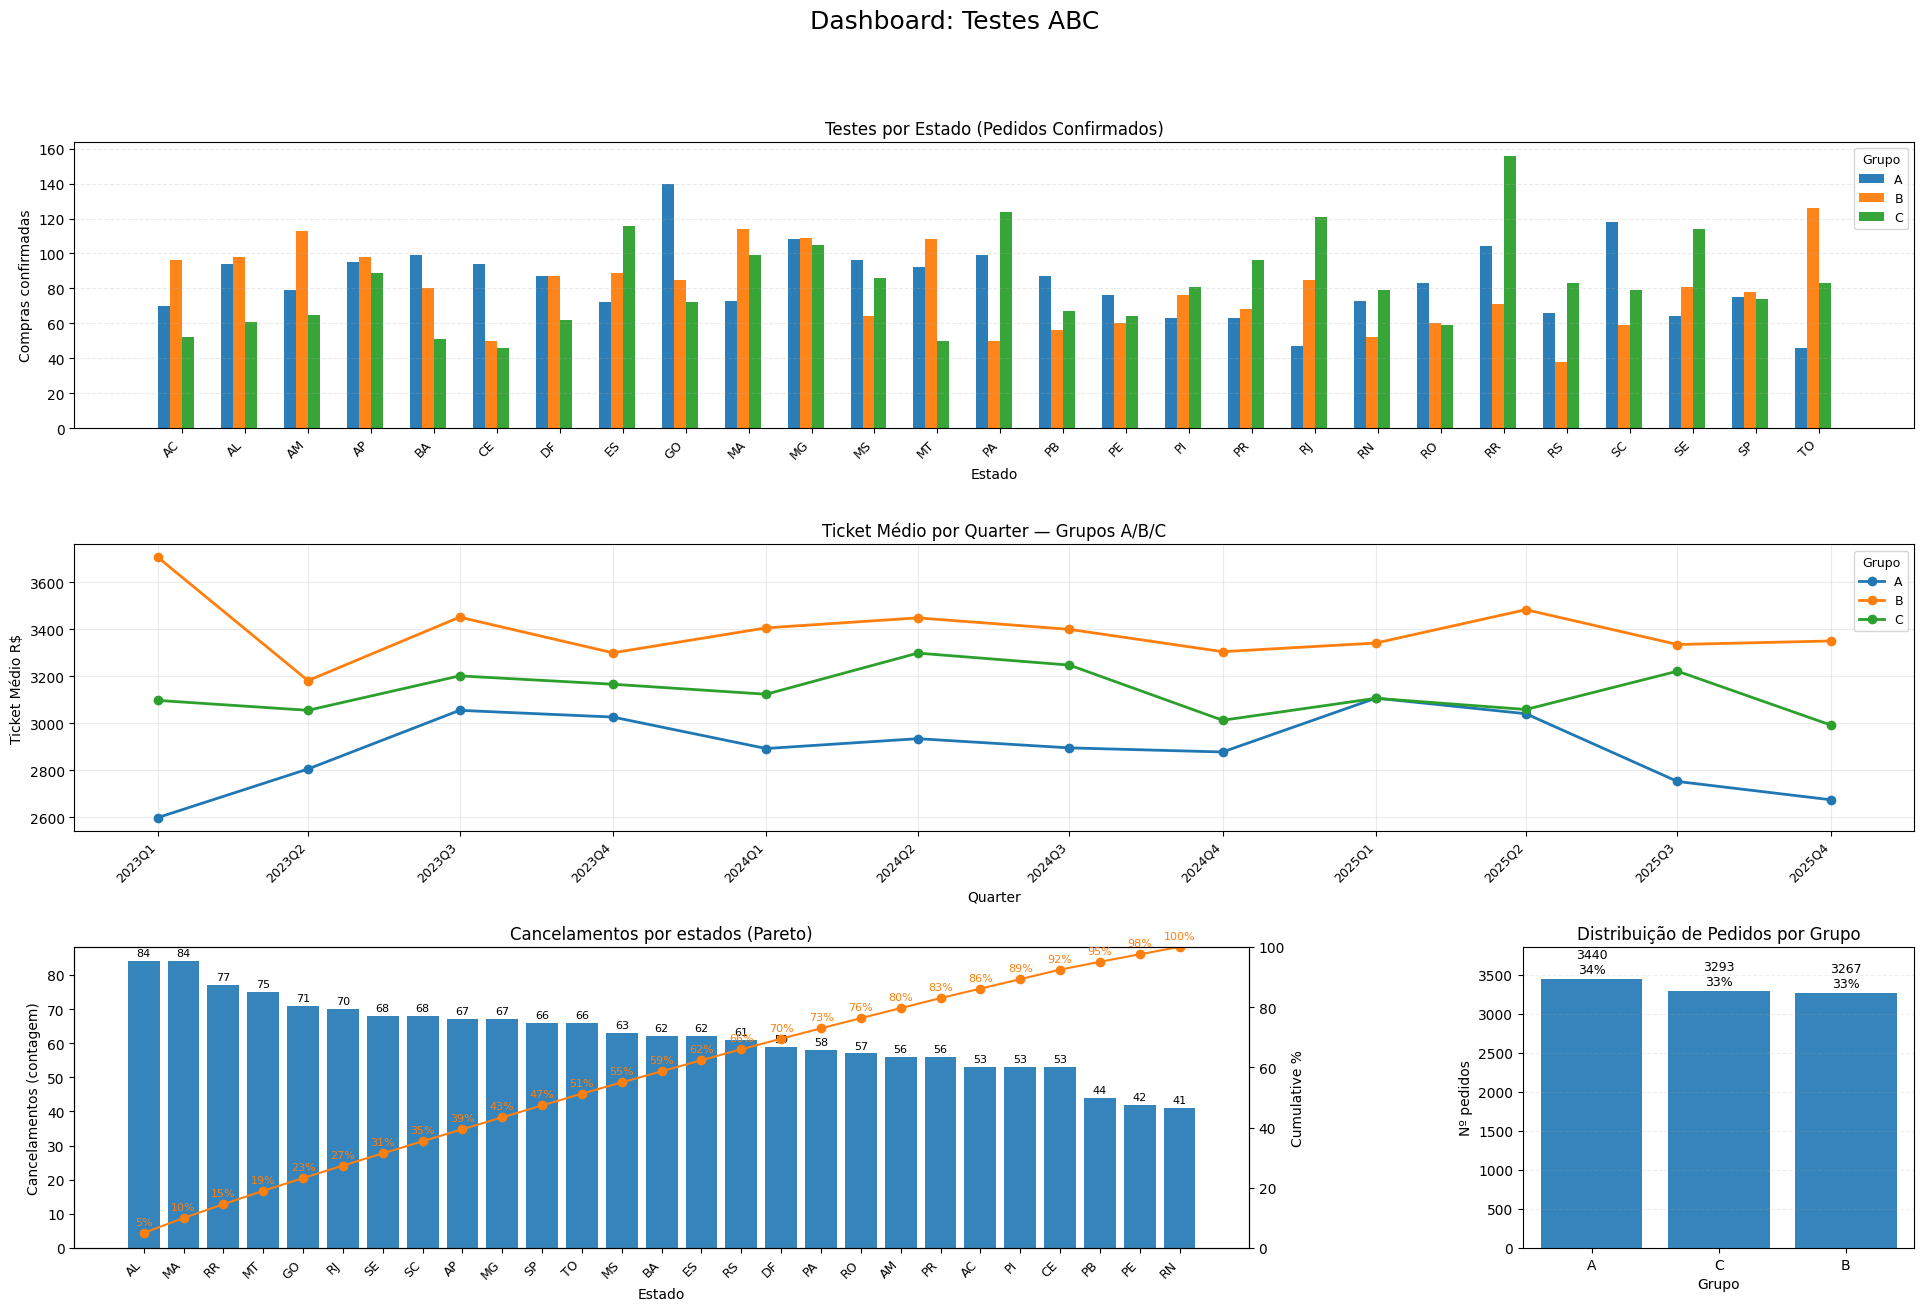

C:\Users\4163819\AppData\Local\Temp\ipykernel_27512\4115442178.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


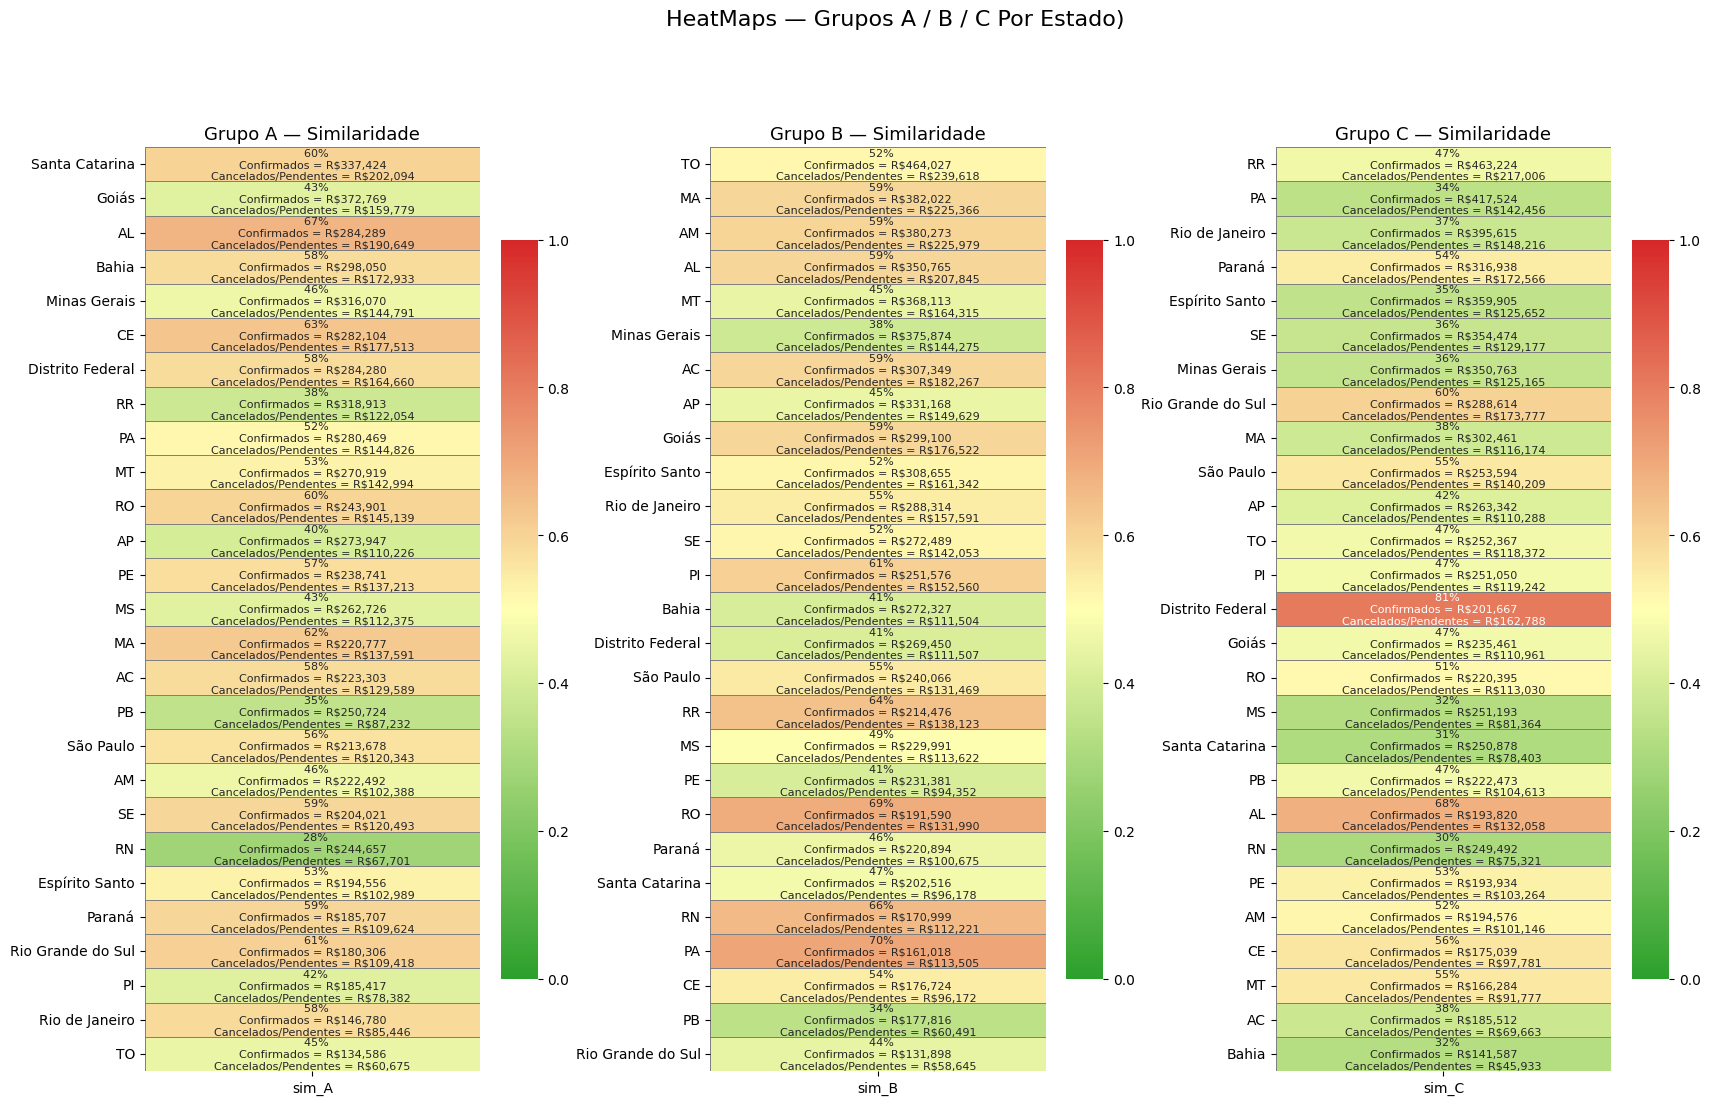

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({'font.size': 10})

# FIGURA 1: Testes / Ticket / Pareto + Distribuição por Grupo (tela 1) 
fig = plt.figure(constrained_layout=False, figsize=(20, 14))

gs = GridSpec(3, 2, figure=fig, height_ratios=[0.95, 0.95, 1.0], width_ratios=[3, 1],
              hspace=0.40, wspace=0.35)

ax1 = fig.add_subplot(gs[0, :])     
ax3 = fig.add_subplot(gs[1, :])     
ax2 = fig.add_subplot(gs[2, 0])      
ax4 = fig.add_subplot(gs[2, 1])      

#Gráfico 1: Testes por Estado
try:
    states = df_pivot.index.tolist()
    groups = df_pivot.columns.tolist()
    n_states = len(states)
    n_groups = len(groups)

    spacing = 1.4
    group_width = 0.8
    width = group_width / max(1, n_groups)
    x = np.arange(n_states) * spacing

    for i, grp in enumerate(groups):
        heights = df_pivot[grp].values
        ax1.bar(x + i*width, heights, width=width, label=str(grp), alpha=0.95)

    ax1.set_xticks(x + group_width/2)
    ax1.set_xticklabels(states, rotation=45, ha="right", fontsize=9)
    ax1.set_xlabel("Estado", fontsize=10)
    ax1.set_ylabel("Compras confirmadas", fontsize=10)
    ax1.set_title("Testes por Estado (Pedidos Confirmados)", fontsize=12)
    ax1.legend(title="Grupo", fontsize=9, title_fontsize=9, loc='upper right')
    ax1.grid(axis='y', linestyle='--', alpha=0.25)
except Exception:
    ax1.text(0.5,0.5, "Erro ao plotar Testes por Estado", ha='center', va='center')
    ax1.set_title("Testes por Estado")

#Gráfico 2: Ticket Médio por Quarter
try:
    if 'df_ticket_q_pivot' in globals() and not df_ticket_q_pivot.empty:
        try:
            labels = df_ticket_q_pivot.index.to_series().dt.to_period('Q').astype(str)
        except Exception:
            labels = [str(i) for i in df_ticket_q_pivot.index]

        for col in df_ticket_q_pivot.columns:
            ax3.plot(df_ticket_q_pivot.index, df_ticket_q_pivot[col], marker='o', linewidth=2, label=str(col))
        max_ticks = 8
        idxs = range(0, len(df_ticket_q_pivot.index), max(1, len(df_ticket_q_pivot.index)//max_ticks))
        ax3.set_xticks(df_ticket_q_pivot.index[list(idxs)])
        ax3.set_xticklabels([labels[i] for i in idxs], rotation=45, ha='right', fontsize=9)

        ax3.set_title("Ticket Médio por Quarter — Grupos A/B/C", fontsize=12)
        ax3.set_xlabel("Quarter", fontsize=10)
        ax3.set_ylabel("Ticket Médio R$", fontsize=10)
        ax3.legend(title="Grupo", fontsize=9, title_fontsize=9, loc='upper right')
        ax3.grid(alpha=0.25)
    else:
        ax3.text(0.5, 0.5, "Dados de ticket por quarter não disponíveis", ha='center', va='center')
        ax3.set_title("Ticket Médio por Quarter — Grupos A/B/C")
except Exception:
    ax3.text(0.5,0.5,"Erro ao plotar Ticket por Quarter", ha='center', va='center')
    ax3.set_title("Ticket Médio por Quarter")

#Gráfico: Pareto de Cancelamentos
try:
    if not df_pareto.empty:
        estados_p = df_pareto['estado'].astype(str).tolist()
        counts_p = df_pareto['cnt'].astype(float).tolist()
        cum_pct = df_pareto['cumulative_pct'].astype(float).tolist()

        ax2.bar(estados_p, counts_p, alpha=0.9)
        ax2.set_xlabel("Estado", fontsize=10)
        ax2.set_ylabel("Cancelamentos (contagem)", fontsize=10)

        ax2_twin = ax2.twinx()
        ax2_twin.plot(estados_p, cum_pct, color='C1', marker='o', linestyle='-', linewidth=1.5)
        ax2_twin.set_ylabel("Cumulative %", fontsize=10)
        ax2_twin.set_ylim(0, 100)

        ax2.set_title("Cancelamentos por estados (Pareto)", fontsize=12)
        ax2.set_xticklabels(estados_p, rotation=45, ha="right", fontsize=9)
        max_v = max(counts_p) if counts_p else 0
        for i, v in enumerate(counts_p):
            ax2.text(i, v + max_v*0.01, str(int(v)), ha='center', va='bottom', fontsize=8)
        for i, p in enumerate(cum_pct):
            ax2_twin.text(i, p + 2, f"{p:.0f}%", ha='center', va='bottom', fontsize=8, color='C1')
    else:
        ax2.text(0.5, 0.5, "Nenhum cancelamento encontrado", ha='center', va='center')
        ax2.set_title("Cancelamentos por estados")
except Exception:
    ax2.text(0.5,0.5,"Erro ao plotar Pareto", ha='center', va='center')
    ax2.set_title("Pareto de Cancelamentos")

# Gráfico: Distribuição de pedidos por grupo
try:
    if 'df_dist' in globals() and not df_dist.empty:
        df_dist_plot = df_dist.sort_values("pedidos", ascending=False).reset_index(drop=True)
        grupos_plot = df_dist_plot['grupo'].fillna("NULO").astype(str).tolist()
        vals = df_dist_plot['pedidos'].astype(int).tolist()
        ax4.bar(grupos_plot, vals, alpha=0.9)
        ax4.set_title("Distribuição de Pedidos por Grupo", fontsize=12)
        ax4.set_ylabel("Nº pedidos", fontsize=10)
        ax4.set_xlabel("Grupo", fontsize=10)

        max_v = max(vals) if vals else 1
        for i, v in enumerate(vals):
            pct = (v / total_pedidos * 100) if ('total_pedidos' in globals() and total_pedidos) else 0
            ax4.text(i, v + max_v*0.01, f"{v}\n{pct:.0f}%", ha='center', va='bottom', fontsize=9)
        ax4.set_ylim(0, max_v*1.12)
        ax4.grid(axis='y', linestyle='--', alpha=0.2)
    else:
        ax4.text(0.5,0.5,"Sem dados de distribuição por grupo", ha='center', va='center')
        ax4.set_title("Distribuição por Grupo")
except Exception:
    ax4.text(0.5,0.5,"Erro ao plotar distribuição", ha='center', va='center')
    ax4.set_title("Distribuição por Grupo")

fig.suptitle("Dashboard: Testes ABC", fontsize=18, y=0.995)
fig.subplots_adjust(top=0.90, left=0.06, right=0.98)
plt.show()


# Gráficos de Heatmap 
fig = plt.figure(constrained_layout=False, figsize=(20, 12))
gs = GridSpec(1, 3, figure=fig, width_ratios=[1,1,1], hspace=0.30, wspace=0.35)

ax4 = fig.add_subplot(gs[0, 0])  
ax5 = fig.add_subplot(gs[0, 1])  
ax6 = fig.add_subplot(gs[0, 2])   

#Config Cores, posicionamento e notações
cmap = LinearSegmentedColormap.from_list("green_yellow_red", ["#2ca02c", "#ffffb2", "#d62728"])
heat_axes = [ax4, ax5, ax6]

for ax, g in zip(heat_axes, grupos):
    try:
        dfg = dfs[g].copy()
    except Exception:
        dfg = pd.DataFrame()

    if dfg.empty:
        ax.text(0.5,0.5, f"Nenhum dado para o grupo {g}", ha='center', va='center', fontsize=12)
        ax.set_title(f"Grupo {g}")
        ax.axis('off')
        continue
    dfg = dfg.sort_values("total_vendas_all", ascending=False).reset_index(drop=True)
    mat = dfg[['similarity']].to_numpy()

    annot = []
    for idx, row in dfg.iterrows():
        sim = row['similarity']
        sim_pct = f"{sim*100:4.0f}%"
        csum = row.get('confirmed_sum', 0.0) or 0.0
        cps = row.get('cancel_pending_sum', 0.0) or 0.0
        csum_s = f"Confirmados = R${csum:,.0f}"
        cps_s  = f"Cancelados/Pendentes = R${cps:,.0f}"
        annot.append(f"{sim_pct}\n{csum_s}\n{cps_s}")
    annot = np.array(annot).reshape(mat.shape)

    states = dfg['estado_nome'].tolist()
    heat_df = pd.DataFrame(mat, index=states, columns=[f"sim_{g}"])

# Configurações do HeatMap
    sns.heatmap(heat_df, ax=ax, cmap=cmap, vmin=0.0, vmax=1.0,
                cbar=True, annot=annot, fmt='', linewidths=0.5,
                linecolor='gray', annot_kws={"fontsize":8}, cbar_kws={"shrink":0.8})
    ax.set_title(f"Grupo {g} — Similaridade", fontsize=13)
    ax.set_xlabel("") 
    ax.set_ylabel("") 
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

fig.suptitle("HeatMaps — Grupos A / B / C Por Estado)", fontsize=16, y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
